In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(15,8)})

path_to_catalog=r'C:\Users\kgrzebien\Desktop\python_tasks\reklamacje\\'


In [229]:
def func_read_data(path):
    df=pd.read_csv(path+'.csv',
              encoding='Cp1250',
              sep="|")
    return df
def func_numer_faktury(df):
    df['FAKTURA_NUMER']=df['FAKTURA'].apply(lambda x: x[4:])
    return df
    
def func_str_to_float(s):
    s=s.astype(str)
    s=s.apply(lambda x: x.replace(',','.'))
    s=s.astype(float)
    return s

def func_add_time(df):
    
    df['Z_DNIA']=pd.to_datetime(df['Z_DNIA'], format='%y/%m/%d')
    
    df['year']=df['Z_DNIA'].apply(lambda x: x.year)
    df['month']=df['Z_DNIA'].apply(lambda x: x.month)
    df['day_of_year']=df['Z_DNIA'].apply(lambda x: x.timetuple().tm_yday)
    df['week']=df['Z_DNIA'].apply(lambda x: x.isocalendar()[1])
    df['week_day']=df['Z_DNIA'].apply(lambda x: x.isocalendar()[2])
    df['year_month']=df['year'].astype(str)+'-'+df['month'].astype(str)+'-'+'01'
    df['year_month']=df['year_month'].apply(lambda x: x[:5]+'0'+x[5:] if len(x)==9 else x)
    df['year_month']=pd.to_datetime(df['year_month'], format='%Y-%m-%d')
    df['year_week']=df['year'].astype(str)+'--'+df['week'].astype(str)
    df['year_week']=df['year_week'].apply(lambda x: x[:6]+'0'+x[6:] if len(x)==7 else x)
    df['year_day']=df['year'].astype(str)+'--'+df['day_of_year'].astype(str)
    df['year_day']=df['year_day'].apply(lambda x: x[:6]+'0'+x[6:] if len(x)<9 else x)
    return df

def func_add_kod_fili(df, col_kod):
    df_filia=pd.read_csv('../słowniki/filie.csv',
                         encoding='Cp1250',
                          sep="|")
    df_filia=df_filia.loc[df_filia['IS_DELETED']=='N'][['KOD','ANALIT01','ANALIT02']]
    df_filia.loc[df_filia.loc[df_filia['KOD']=='LI'].index, 'ANALIT01']='LI'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='LI'].index, 'ANALIT02']='LIKWIDACJA'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='00'].index, 'ANALIT01']='00'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='00'].index, 'ANALIT02']='MAGAZYN_00'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='65'].index, 'ANALIT01']='FE'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='65'].index, 'ANALIT02']='FELER'
    df=df.merge(df_filia, how='left', left_on=col_kod, right_on='KOD')
    return df

def func_add_slownik(df):
    df_slownik=pd.read_csv('../słowniki/slownik.csv',
                           encoding='Cp1250',
                          sep="|")
    df_slownik=df_slownik.loc[df_slownik['IS_DELETED']=='N'][['KOD_TEMA','ZNACZNIK','DOSTAWCA']]
    df=df.merge(df_slownik, how='left', on='KOD_TEMA')
    df=func_add_znacznik(df)
    return df

def func_add_znacznik(df):
    df_znacznik=pd.read_csv('../słowniki/znacznik.csv',
                            encoding='Cp1250',
                              sep="|")
    df_znacznik=df_znacznik.loc[df_znacznik['IS_DELETED']=='N'][['ZNACZNIK','NAZWA']]
    df_znacznik=df_znacznik.rename(columns={'NAZWA':'NAZWA_ZNACZNIK'})
    df=df.merge(df_znacznik, how='left', on='ZNACZNIK')
    return df

def func_sell(path):
    df=pd.read_csv('../sprzedaz_fakty_bi/'+path+'.csv',
                            encoding='Cp1250',
                              sep="|")
    df=func_add_slownik(df)
    df=func_add_time(df)
    df['WARTOB_SUM']=func_str_to_float(df['WARTOB_SUM'])
    df['ILOSC_SUM']=func_str_to_float(df['ILOSC_SUM'])
    df=func_add_kod_fili(df, 'FILIA')
    return df

In [230]:
df_sell=func_sell('hurtbi_fakty_sprz_22')


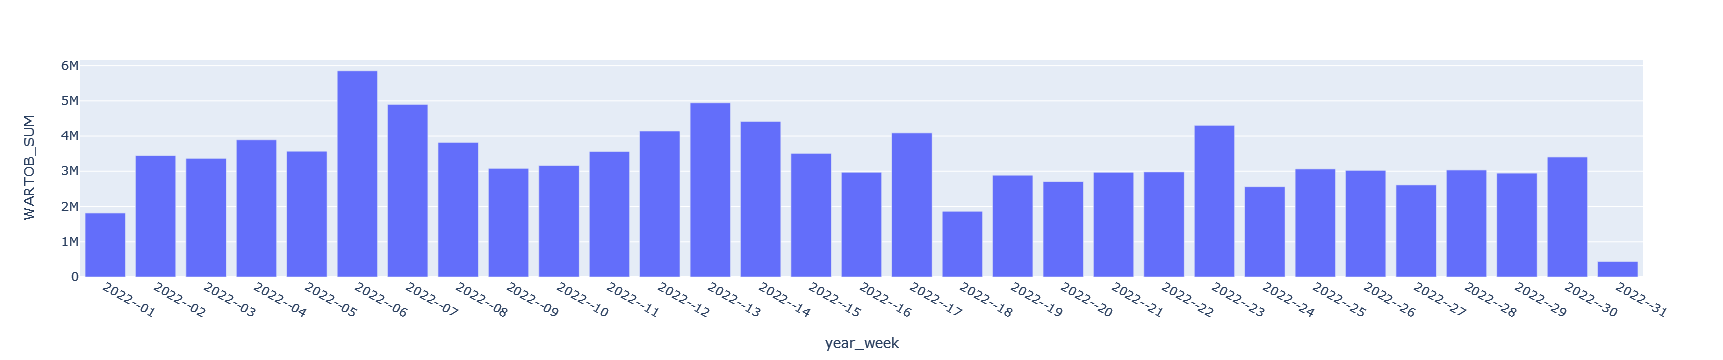

In [237]:
px.bar(df_sell.groupby(['year_week']).agg({'WARTOB_SUM':'sum'}).reset_index(),
x='year_week',
y='WARTOB_SUM')

In [231]:
df_fi=func_read_data('f56fi_wszystkie_kody_fili')
df_fi=func_numer_faktury(df_fi)
df_fi=func_add_slownik(df_fi)
df_fi=func_add_time(df_fi)
df_fi['WARTOSC_B']=func_str_to_float(df_fi['WARTOSC_B'])
df_fi['ILOSC']=func_str_to_float(df_fi['ILOSC'])
df_fi=func_add_kod_fili(df_fi, 'KOD')

In [232]:
df_fi.groupby(['ANALIT01','ANALIT02']).agg({'FAKTURA':'nunique',
                                      'ILOSC':'sum'}).sort_values(by='FAKTURA', ascending=False)

FAKTURA      ILOSC
ANALIT01 ANALIT02                      
00       MAGAZYN_00    18615  163290.22
OU       OUTLET         3517   12821.66
LI       LIKWIDACJA     2120    5858.30
FE       FELER           674    5338.12
                         406    7554.98
SF                        29     128.10
SW       BIELSKO           7      15.30
         JANKI             7     451.00
         RZESZÓW           7      26.60
         CZĘSTOCHOW        5      19.00
         SZCZECIN          5      27.00
         ŁÓDŹ              3      19.00
         KALISZ            1      10.00
         PŁOCK             1       6.00
         RADOM             1       6.00
         WŁOCŁAWEK         1       6.00

In [62]:
for i in ['LI','FE', 'OU']:
    display(i, df_fi.loc[df_fi['ANALIT01']==i].groupby('RODZAJ').agg({'ILOSC':'sum'}).sort_values(by='ILOSC', ascending=False))

'LI'

,ILOSC
RODZAJ,
140X250 PRZEL,457.0
0.38,424.0
0.61,300.0
70X140 (X3) 500,272.0
50X90 (X6) 500,248.0
...,...
0.70/1301 WHITE,0.3
0.90,0.3
0.90/1301 WHITE,0.3


'FE'

,ILOSC
RODZAJ,
140X250 PRZEL,254.0
AB098-3,160.0
300/17489,155.6
300/WHITE,130.2
140X270 T,128.0
...,...
280/HRT-38685,0.6
300/12,0.6
280/81558,0.5


'OU'

,ILOSC
RODZAJ,
140X250 PRZEL,567.00
140X270 T,332.00
0.50,293.00
0.80,200.00
ZIEL,176.00
...,...
300/BEŻ+TURK,0.90
280/5,0.90
280/45151,0.75


In [105]:
df_szac=func_read_data('f56szac')
df_szac=func_numer_faktury(df_szac)
df_szac=func_add_slownik(df_szac)
df_szac=func_add_time(df_szac)
df_szac['CENA_Z1']=func_str_to_float(df_szac['CENA_Z1'])
df_szac['CENA_Z2']=func_str_to_float(df_szac['CENA_Z2'])

In [86]:
df_szac['uz_nr']=df_szac['UZASADNIEN'].apply(lambda x: x[-8:])

In [20]:
df_szac.groupby(['OPIS']).agg({'FAKTURA':'nunique'}).sort_values(by='FAKTURA')

,FAKTURA
OPIS,
",",1
KV5600000360 KF5622/00009,1
KV5600000359 KF5622/00008,1
KATIE/ZAS/ST+SRE 280,1
GRANIT/ZAS/POPI 285/29265-1,1
...,...
ADEN/B 300,6
Nowe pozycje stanu,11
Zmiana stanu,86


In [80]:
df_fi.merge(df_szac, how='inner', left_on='FAKTURA_NUMER', right_on='uz_nr')

,FAKTURA_x,FAKTURA_FK,Z_DNIA_x,WARTOSC_B,KOD,OPIS_x,NAZWA,RODZAJ,KOD_TEMA_x,ILOSC,FAKTURA_NUMER_x,year_x,month_x,day_of_year_x,week_x,week_day_x,year_month_x,year_week_x,year_day_x,ANALIT01,ANALIT02,FAKTURA_y,FK,Z_DNIA_y,OPIS_y,TYP_PRZESZ,UZASADNIEN,NAZWA1,NAZWA2,KOD_TEMA_y,ILOSC1,ILOSC2,CENA_Z1,CENA_Z2,FAKTURA_NUMER_y,year_y,month_y,day_of_year_y,week_y,week_day_y,year_month_y,year_week_y,year_day_y,uz_nr
0,MM5600139273,,2022-04-05,32.53,K1,0,F/ZAS/INGRID/GF+,140X250 PRZEL,368329,1.0,00139273,2022,4,95,14,2,2022-04-01,2022--14,2022--095,OU,OUTLET,SC5600033841,N,2022-01-10,Przecena towaru,8,Na podstawie korekty: ZF5600139273,POS/ST/BLINK/2,POS/ST/BLINK/2,383308,1,0,58.63,58.63,00033841,2022,1,10,2,1,2022-01-01,2022--02,2022--010,00139273
1,MM5600139273,,2022-04-05,32.53,K1,0,F/ZAS/INGRID/GF+,140X250 PRZEL,368329,1.0,00139273,2022,4,95,14,2,2022-04-01,2022--14,2022--095,OU,OUTLET,SC5600033841,N,2022-01-10,Przecena towaru,8,Na podstawie korekty: ZF5600139273,F/POS/ST/BLINK/2,F/POS/ST/BLINK/2,406273,0,1,58.63,58.63,00033841,2022,1,10,2,1,2022-01-01,2022--02,2022--010,00139273
2,MM5600139273,,2022-04-05,32.53,K1,0,F/ZAS/INGRID/GF+,140X250 PRZEL,368329,1.0,00139273,2022,4,95,14,2,2022-04-01,2022--14,2022--095,OU,OUTLET,SC5600033841,N,2022-01-10,Przecena towaru,8,Na podstawie korekty: ZF5600139273,MS/POS/ST/AIDA,MS/POS/ST/AIDA,364528,1,0,90.61,90.61,00033841,2022,1,10,2,1,2022-01-01,2022--02,2022--010,00139273
3,MM5600139273,,2022-04-05,32.53,K1,0,F/ZAS/INGRID/GF+,140X250 PRZEL,368329,1.0,00139273,2022,4,95,14,2,2022-04-01,2022--14,2022--095,OU,OUTLET,SC5600033841,N,2022-01-10,Przecena towaru,8,Na podstawie korekty: ZF5600139273,F/MS/POS/ST/AIDA,F/MS/POS/ST/AIDA,381174,0,1,90.61,90.61,00033841,2022,1,10,2,1,2022-01-01,2022--02,2022--010,00139273
4,MM5600139273,,2022-04-05,32.53,K1,0,F/ZAS/INGRID/GF+,140X250 PRZEL,368329,1.0,00139273,2022,4,95,14,2,2022-04-01,2022--14,2022--095,OU,OUTLET,SC5600033841,N,2022-01-10,Przecena towaru,8,Na podstawie korekty: ZF5600139273,CHP/STELA/K+ZŁOT,CHP/STELA/K+ZŁOT,381911,1,0,8.38,8.38,00033841,2022,1,10,2,1,2022-01-01,2022--02,2022--010,00139273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,MM5600147769,,2022-06-20,653.38,00,38,ZAS/RIA/K,140X250 PRZE 10,366802,2.0,00147769,2022,6,171,25,1,2022-06-01,2022--25,2022--171,00,MAGAZYN_00,SC5600034162,N,2022-01-26,Przecena towaru,8,Na podstawie korekty: ZF5600147769,F/FIR/BELISSA/B,F/FIR/BELISSA/B,404980,0,1,26.89,26.89,00034162,2022,1,26,4,3,2022-01-01,2022--04,2022--026,00147769
408,MM5600147769,,2022-06-20,653.38,00,38,ZAS/ADELLE/STA,140X250 PRZEL,367154,2.0,00147769,2022,6,171,25,1,2022-06-01,2022--25,2022--171,00,MAGAZYN_00,SC5600034162,N,2022-01-26,Przecena towaru,8,Na podstawie korekty: ZF5600147769,FIR/BELISSA/B,FIR/BELISSA/B,390143,1,0,26.89,26.89,00034162,2022,1,26,4,3,2022-01-01,2022--04,2022--026,00147769
409,MM5600147769,,2022-06-20,653.38,00,38,ZAS/ADELLE/STA,140X250 PRZEL,367154,2.0,00147769,2022,6,171,25,1,2022-06-01,2022--25,2022--171,00,MAGAZYN_00,SC5600034162,N,2022-01-26,Przecena towaru,8,Na podstawie korekty: ZF5600147769,F/FIR/BELISSA/B,F/FIR/BELISSA/B,404980,0,1,26.89,26.89,00034162,2022,1,26,4,3,2022-01-01,2022--04,2022--026,00147769
410,MM5600147769,,2022-06-20,653.38,00,38,LC/LOTOS4/ZAS,140X250 PRZEL TUR+ZŁ,394391,2.0,00147769,2022,6,171,25,1,2022-06-01,2022--25,2022--171,00,MAGAZYN_00,SC5600034162,N,2022-01-26,Przecena towaru,8,Na podstawie korekty: ZF5600147769,FIR/BELISSA/B,FIR/BELISSA/B,390143,1,0,26.89,26.89,00034162,2022,1,26,4,3,2022-01-01,2022--04,2022--026,00147769


In [81]:
df_fi.loc[df_fi['FAKTURA_NUMER']=='00139273']

,FAKTURA,FAKTURA_FK,Z_DNIA,WARTOSC_B,KOD,OPIS,NAZWA,RODZAJ,KOD_TEMA,ILOSC,FAKTURA_NUMER,year,month,day_of_year,week,week_day,year_month,year_week,year_day,ANALIT01,ANALIT02
41554,MM5600139273,,2022-04-05,32.53,K1,0,F/ZAS/INGRID/GF+,140X250 PRZEL,368329,1.0,00139273,2022,4,95,14,2,2022-04-01,2022--14,2022--095,OU,OUTLET


In [87]:
df_szac.loc[df_szac['uz_nr']=='00139273']

,FAKTURA,FK,Z_DNIA,OPIS,TYP_PRZESZ,UZASADNIEN,NAZWA1,NAZWA2,RODZAJ1,RODZAJ2,KOD_TEMA,ILOSC1,ILOSC2,CENA_Z1,CENA_Z2,FAKTURA_NUMER,year,month,day_of_year,week,week_day,year_month,year_week,year_day,uz_nr
2343,SC5600033841,N,2022-01-10,Przecena towaru,8,Na podstawie korekty: ZF5600139273,POS/ST/BLINK/2,POS/ST/BLINK/2,220X200 70X80/X2 CZA,220X200 70X80/X2 CZA,383308,1,0,58.63,58.63,00033841,2022,1,10,2,1,2022-01-01,2022--02,2022--010,00139273
2344,SC5600033841,N,2022-01-10,Przecena towaru,8,Na podstawie korekty: ZF5600139273,F/POS/ST/BLINK/2,F/POS/ST/BLINK/2,220X200 70X80/X2 CZA,220X200 70X80/X2 CZA,406273,0,1,58.63,58.63,00033841,2022,1,10,2,1,2022-01-01,2022--02,2022--010,00139273
2345,SC5600033841,N,2022-01-10,Przecena towaru,8,Na podstawie korekty: ZF5600139273,MS/POS/ST/AIDA,MS/POS/ST/AIDA,220X200 70X80/X2,220X200 70X80/X2,364528,1,0,90.61,90.61,00033841,2022,1,10,2,1,2022-01-01,2022--02,2022--010,00139273
2346,SC5600033841,N,2022-01-10,Przecena towaru,8,Na podstawie korekty: ZF5600139273,F/MS/POS/ST/AIDA,F/MS/POS/ST/AIDA,220X200 70X80/X2,220X200 70X80/X2,381174,0,1,90.61,90.61,00033841,2022,1,10,2,1,2022-01-01,2022--02,2022--010,00139273
2347,SC5600033841,N,2022-01-10,Przecena towaru,8,Na podstawie korekty: ZF5600139273,CHP/STELA/K+ZŁOT,CHP/STELA/K+ZŁOT,45X45 K+ZŁOT,45X45 K+ZŁOT,381911,1,0,8.38,8.38,00033841,2022,1,10,2,1,2022-01-01,2022--02,2022--010,00139273
2348,SC5600033841,N,2022-01-10,Przecena towaru,8,Na podstawie korekty: ZF5600139273,F/CHP/STELA/K+ZŁ,F/CHP/STELA/K+ZŁ,45X45 K+ZŁOT,45X45 K+ZŁOT,406272,0,1,8.38,8.38,00033841,2022,1,10,2,1,2022-01-01,2022--02,2022--010,00139273


In [226]:
def func_plot_scatter(df, dict_agg, gr):
    df=df.loc[df['ANALIT01'].isin(['LI','FE', 'OU'])].groupby([gr]).agg(dict_agg).sort_values(by='ILOSC', ascending=False).reset_index()
    fig=px.scatter(df,
                  x=gr,
                  y='ILOSC',
                  #color='NAZWA_ZNACZNIK',
                  height=600)#,
                  #log_y=True)
    fig.show()
    
    _=df[dict_agg.keys()]/df[dict_agg.keys()].sum()*100
    _1=(df[dict_agg.keys()]/df[dict_agg.keys()].sum()*100).cumsum()
    display(df[[gr]].merge(_, how='left', left_index=True, right_index=True).merge(_1, how='left', left_index=True, right_index=True))
    return

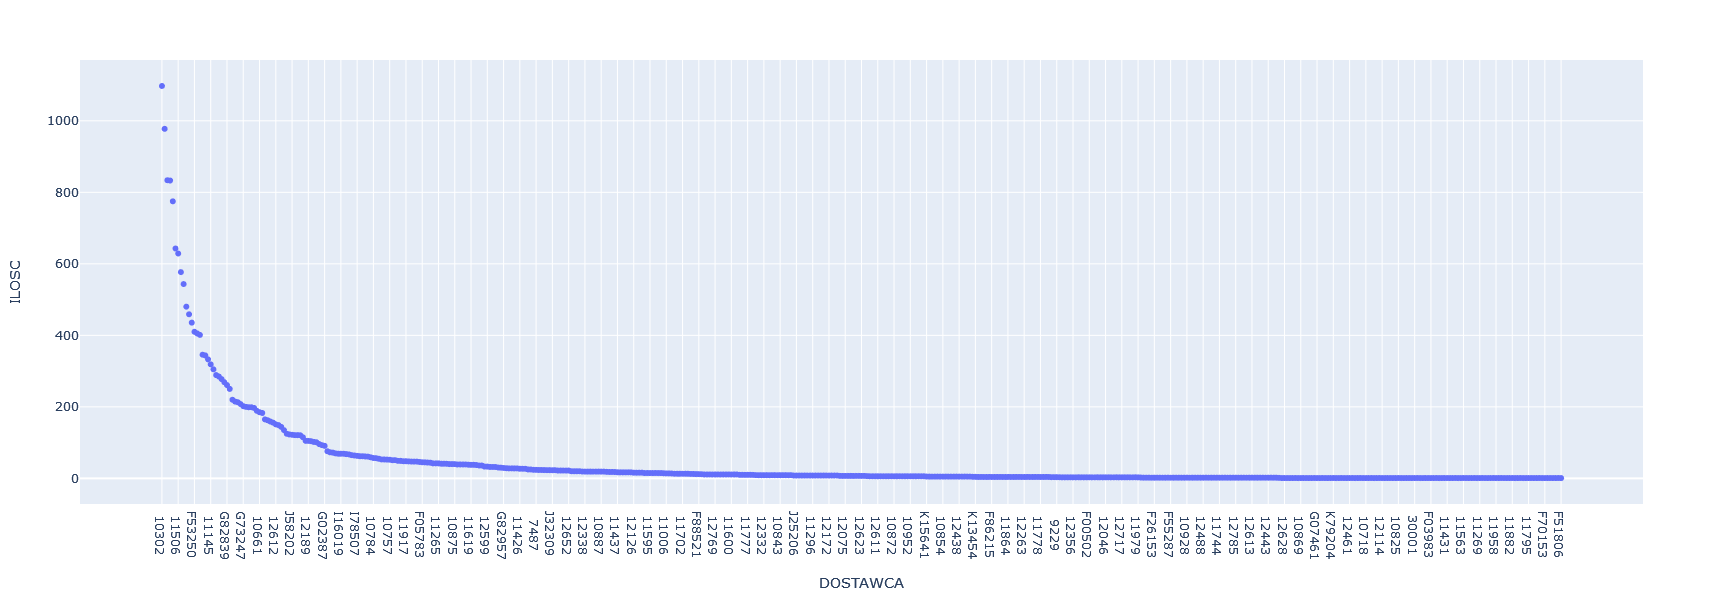

,DOSTAWCA,ILOSC_x,ILOSC_y
0,10302,4.604674,4.604674
1,11447,4.101621,8.706294
2,H00846,3.498503,12.204797
3,9469,3.494937,15.699734
4,11859,3.251592,18.951326
...,...,...,...
512,F69236,0.004196,99.983637
513,11131,0.004196,99.987833
514,12818,0.004196,99.992028
515,12350,0.004196,99.996224


In [195]:
func_plot_scatter(df_fi, {'ILOSC':'sum'}, 'DOSTAWCA')

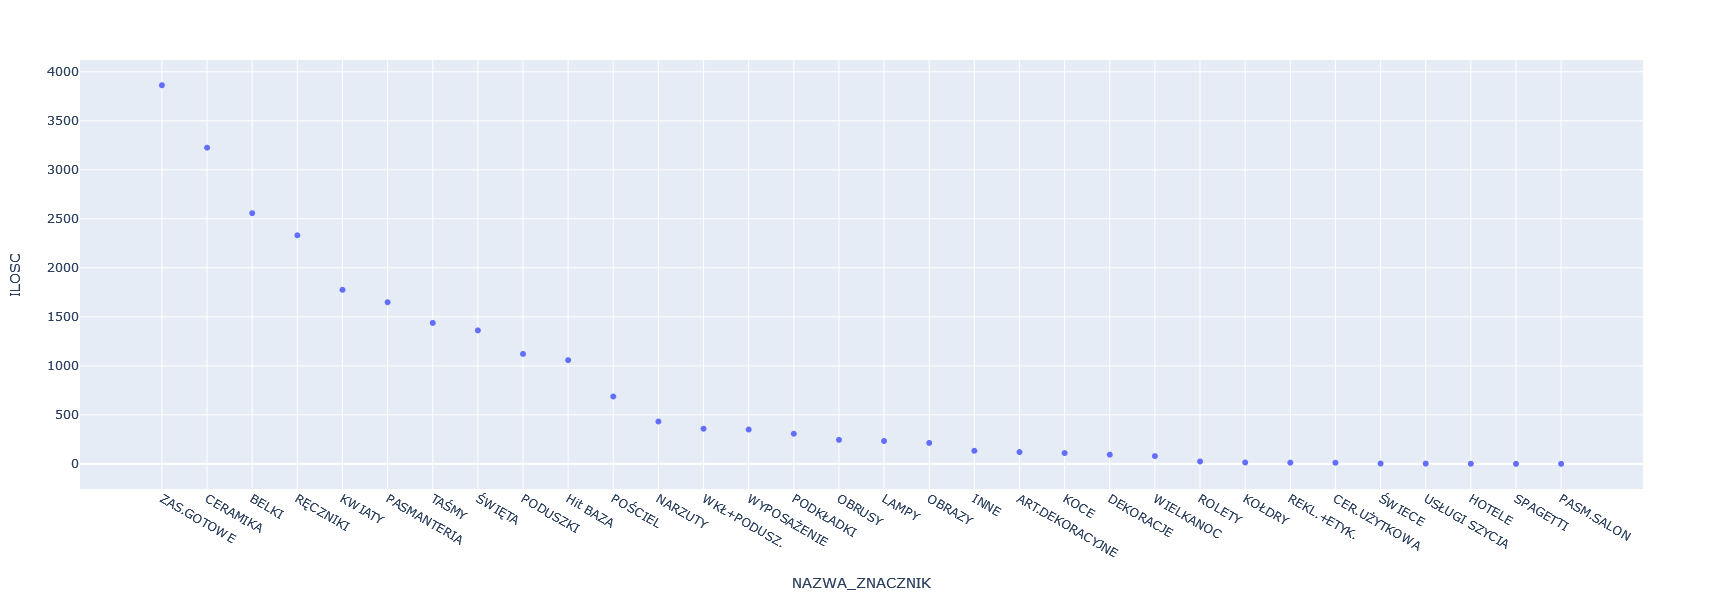

,NAZWA_ZNACZNIK,ILOSC_x,ILOSC_y
0,ZAS.GOTOWE,16.207612,16.207612
1,CERAMIKA,13.535013,29.742625
2,BELKI,10.731008,40.473633
3,RĘCZNIKI,9.784145,50.257778
4,KWIATY,7.451390,57.709168
5,PASMANTERIA,6.919345,64.628513
6,TAŚMY,6.035374,70.663887
7,ŚWIĘTA,5.714410,76.378297
8,PODUSZKI,4.707466,81.085763
9,Hit BAZA,4.441884,85.527647


In [227]:
func_plot_scatter(df_fi, {'ILOSC':'sum'}, 'NAZWA_ZNACZNIK')

In [200]:
df_fi.loc[df_fi['NAZWA_ZNACZNIK']=='ZAS.GOTOWE']['NAZWA'].unique()[:50]

array(['ZAS/SPECIAL/B', 'ZAS/ELIE/B+RÓŻ', 'FIR/ESIM/B', 'ZAS/MARIAH/K+MU',
       'FIR/SEYLAN/B+SRE', 'FIR/SEHER/B+SRE', 'FIR/KATRIANA/B',
       'FIR/ANIKA/TURK', 'FIR/BENAY/NIE+SR', 'FIR/TAMAY/RÓŻ',
       'FIR/TAMAY/TURK', 'FIR/SYLVIA/B', 'D91/Z/ADEL/TURK',
       'LC/PEONIA1/ZAS', 'D91/Z/JULIET', 'FIR/CARLA/B', 'FIR/SIBEL/B+SRE',
       'FIR/SIBEL/B+SZAM', 'ZAS/ANGELINA/TUR', 'ZAS/CARLO/BEŻ',
       'ZAS/MILAN/GRAN', 'D91/Z/PARISA/GRA', 'ZAS/MILA/B+RUD',
       'ZAS/RIA/STAL', 'ZAS/SAMANTA/TUR', 'F/ZAS/VILMA/NIE',
       'ZAS/EVITA/GRAN', 'ZAS/EVITA/STAL', 'ZAS/RIA/MORS',
       'ZAS/VILLA/BEŻ', 'ZAS/PIERRE/STA', 'ZAS/VILLA/OLIW',
       'ZAS/LOGAN/TURK', 'ZAS/LOGAN/B', 'FIR/ARGEA/RÓŻ', 'ZAS/VILLA/GRAF',
       'ZAS/RIA/C.BORD', 'ZAS/RIA/C.RÓŻ', 'ZAS/PIERRE/C.ZIE',
       'F/FIR/LUCY/B', 'F/D91/Z/ROSA/PUD', 'ZAS/VILLA/C.BORD',
       'ZAS/PIERRE/SRE', 'FIR/LUCY/K', 'ZAS/EVELYNE/GRAN',
       'ZAS/DARCY/BEŻ', 'ZAS/DARCY/SR', 'ZAS/DARCY/CZAR', 'PIER/ZAS/ZOJA',
       'ZAS/PIERRE/BEŻ'

In [156]:
df_fi.loc[df_fi['ANALIT01'].isin(['LI','FE', 'OU'])].groupby(['DOSTAWCA']).agg({'NAZWA_ZNACZNIK':'nunique'}).sort_values(by='NAZWA_ZNACZNIK')

,NAZWA_ZNACZNIK
DOSTAWCA,
12488,1
12769,1
12764,1
12762,1
12761,1
...,...
F53250,4
11447,5
8097,5


In [214]:
for i in _.columns:
    if 'KOD' in i:
        print(i)

KOD_TEMA
KOD_TEMA_W
KOD_TEMA_K
KOD_PASEK
KOD_HS
KOD_PROMOC
KOD_PRODUC
KOD_PCN
KOD_KR
KOD_KOLOR
KOD_METKI
KOD_KUPCA
KOD_ZAOPAT
KOD_KRES
STAN_KODPL
KOD_GTU
KOD_CN
KOD_PROC
KOD_BLOZ


In [ ]:
kod_wlasny==8

In [218]:
_s=pd.read_csv('../sprzedaz_fakty_bi/hurtbi_fakty_sprz_22.csv',encoding='Cp1250',
              sep="|")

In [142]:
_z=pd.read_csv('../słowniki/znacznik.csv',encoding='Cp1250',
              sep="|")[['ZNACZNIK','NAZWA']]

In [144]:
_z.loc[_z['ZNACZNIK']==91]

,ZNACZNIK,NAZWA
38,91,USŁUGI SZYCIA


In [203]:
_=pd.read_csv('../słowniki/slownik.csv',encoding='Cp1250',
              sep="|")#[['KOD_TEMA','ZNACZNIK','DOSTAWCA']]

In [145]:
_=_.merge(_z, how='left',on='ZNACZNIK')

In [140]:
np.sort(_['KOD_TEMA'].unique())

array([-10056, -10055, -10054, ..., 999997, 999998, 999999], dtype=int64)

In [147]:
_.loc[_['KOD_TEMA']<0]['NAZWA'].unique()

array(['INNE', 'USŁUGI SZYCIA', 'USŁUGI TRANSPORT', 'USŁUGI POS',
       'KARNISZE', 'USŁUGI INNE', 'USŁUGI ZAKUP', 'USŁUGI MONTAŻ',
       'USŁUGI ROLETY'], dtype=object)

In [149]:
pd.read_csv('../sprzedaz_fakty_bi/hurtbi_fakty_sprz_22.csv',encoding='Cp1250',
              sep="|")

,FAKTURA,DOKUMENT,Z_DNIA,FILIA,KOD_TEMA,TYP_DOK,JAK_POWST,WARTOB,ILOSC
0,FVM200002309,FM2A22/00002,22/01/03,M2,-10000.0,FV,K,0,0
1,FVM200002309,FM2A22/00002,22/01/03,M2,378079.0,FV,K,424,"10,6"
2,FVM200002309,FM2A22/00002,22/01/03,M2,378911.0,FV,K,340,"8,5"
3,FVM200002309,FM2A22/00002,22/01/03,M2,65080.0,FV,K,452,20
4,FVM200002309,FM2A22/00002,22/01/03,M2,50502.0,FV,K,44,200
...,...,...,...,...,...,...,...,...,...
536295,KV0000121311,KF0022/09742,22/03/28,0.0,3895.0,KV,ZI2O#,"-26,25",-1
536296,KV0000119927,KF0022/08378,22/03/16,0.0,387969.0,KV,Z,"-64,98",-1
536297,KV0000120112,KF0022/08563,22/03/17,0.0,62937.0,KV,ZI2O#,"-79,19","-5,6"
536298,KV0000117196,KF0022/05726,22/03/03,0.0,93844.0,KV,A,"-1,88",-1


In [88]:
import cx_Oracle

try:
    host = '192.168.0.206'
    port = 1521
    SID = 'orcl'
    
    dsn = cx_Oracle.makedsn(host, port, SID)
    
    connection = cx_Oracle.connect(user="EF_KG",
                                  password='',
                                  dsn=dsn,
                                   encoding="UTF-8")

    # show the version of the Oracle Database
    print(connection.version)
except cx_Oracle.Error as error:
    print(error)
finally:
    # release the connection
    if connection:
        connection.close()


DPI-1047: Cannot locate a 64-bit Oracle Client library: "The specified module could not be found". See https://cx-oracle.readthedocs.io/en/latest/user_guide/installation.html for help


NameError: name 'connection' is not defined